In [0]:
# Pre required libraries and models
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn import Conv1d, MaxPool1d, Flatten, Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import L1Loss
!pip install pytorch.ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

  Using cached https://files.pythonhosted.org/packages/35/55/41e8a995876fd2ade29bdba0c3efefa38e7d605cb353c70f3173c04928b5/pytorch_ignite-0.3.0-py2.py3-none-any.whl


In [0]:
def getDataset():
  url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
  dataset = pd.read_csv(url)
  print(dataset.head())
  return dataset

In [0]:
def dataVisualization(dataset):
  print("First Ten recoreds of dataset")
  print(dataset.head(n=10))
  print("Plot Each Feature of the dataset on the Seperate Sub-plot")
  print(dataset.plot(subplots=True))

In [0]:
def checkingAndRemovingNullValues(dataset):
  # Checking Missing Values
  print("Checking Missing Values")
  print(dataset.isnull().sum())
  print("Removing Missing Values")
  dataset = dataset.dropna()
  print(dataset.isnull().sum())
  return dataset

In [0]:
def removingOutliers(dataset):
  dataset.describe()
  #we can see that area where median price frequencey for >= 500000 is more and could be a outlier or wrong data
  plt.figure(figsize=(10,6))
  sns.distplot(dataset['median_house_value'],color='green')
  plt.show()
  dataset[dataset['median_house_value']>450000]['median_house_value'].value_counts().head()
  dataset=dataset.loc[dataset['median_house_value']<500001,:]
  dataset=dataset[dataset['population']<25000]
  return dataset

In [0]:
def loadDataSet(dataset):
  Y = dataset['median_house_value']
  X = dataset.loc[:,'longitude':'median_income']
  x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=2003)
  return x_train,x_test,y_train,y_test,X

In [0]:
def normalizingData(x_train,x_test,y_train,y_test):
  sc = StandardScaler()
  x_train_np=sc.fit_transform(x_train)
  x_test_np=sc.transform(x_test)
  y_train_np = y_train.to_numpy()
  y_test_np = y_test.to_numpy()
  return x_train_np,x_test_np,y_train_np,y_test_np

In [0]:
class _1100690_1dconv_reg(torch.nn.Module):
  def __init__(self,batch_size,inputs, outputs):
    super(_1100690_1dconv_reg,self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs,batch_size,1)
    self.max_pooling_layer = MaxPool1d(1)
    self.con_layer = Conv1d(batch_size,128,1)
    self.con_layer1 = Conv1d(128,64,1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(64,64)
    self.output_layer = Linear(64,outputs)
  
  def feed(self,input):
    input = input.reshape((self.batch_size,self.inputs,1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.con_layer(output))
    output = relu(self.con_layer1(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0 
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions,output)
    score_metric.update([predictions,output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss += loss.item()
    avg_score += score
    count+=1
  return avg_loss/count,avg_score/count

In [0]:
def trainModel(model,x_train_np,y_train_np,batch_size):
  epochs = 300

  optimizer = Adam(model.parameters(),lr=1e-1)

  inputs = torch.from_numpy(x_train_np).cuda().float()
  outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

  tensor = TensorDataset(inputs,outputs)
  loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

  for epoch in range(epochs):
    avg_loss, avg_r2_score = model_loss(model,loader,train=True,optimizer=optimizer)
    print('Epoch'+str(epoch+1)+":\n\tLoss=" + str(avg_loss) + "\n\tR^2 Score = "+ str(avg_r2_score))

In [0]:
def testModel(model,x_test_np,y_test_np,batch_size):
  inputs = torch.from_numpy(x_test_np).cuda().float()
  outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

  tensor = TensorDataset(inputs,outputs)
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)

  start.record()
  loader = DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
  end.record()

  # Waits for everything to finish running
  torch.cuda.synchronize()

  print("Inference Time: ",start.elapsed_time(end))
  

  avg_loss, avg_r2_score = model_loss(model,loader)
  print("The model's l1 loss is :" + str(avg_loss))
  print("The model's R^2 score is :" + str(avg_r2_score))

In [0]:
def run_assignment():
  dataset = getDataset()
  dataVisualization(dataset)
  dataset = checkingAndRemovingNullValues(dataset)
  dataset = removingOutliers(dataset)
  x_train,x_test,y_train,y_test,X = loadDataSet(dataset)
  x_train_np,x_test_np,y_train_np,y_test_np=normalizingData(x_train,x_test,y_train,y_test)
  # Define Model
  batch_size = 64
  model = _1100690_1dconv_reg(batch_size,X.shape[1],1)
  print(model.cuda())
  trainModel(model,x_train_np,y_train_np,batch_size)
  testModel(model,x_test_np,y_test_np,batch_size)
  

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]
First Ten recoreds of dataset
   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY
5    -122.25     37.85  ...            269700.0         NEAR BAY
6    -122.25     37.84  ...            299200.0         NEAR BAY
7    -122.25     37.84  ...          

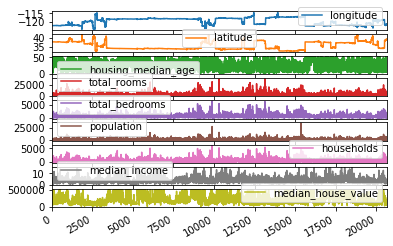

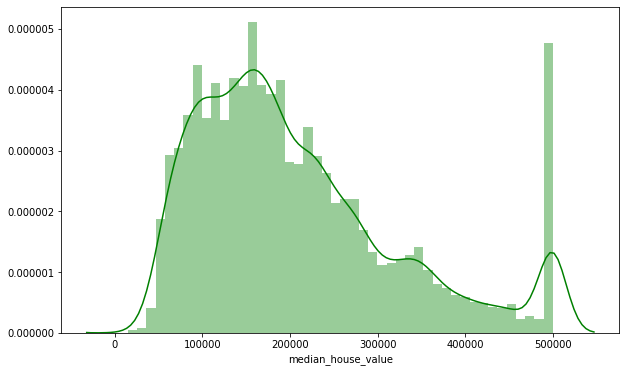

_1100690_1dconv_reg(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (con_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (con_layer1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Epoch1:
	Loss=53920.53691590507
	R^2 Score = -0.20053160041963328
Epoch2:
	Loss=45055.754219487026
	R^2 Score = 0.5784560254339871
Epoch3:
	Loss=43463.191931382666
	R^2 Score = 0.5903996173875181
Epoch4:
	Loss=43746.23286409198
	R^2 Score = 0.599739004214687
Epoch5:
	Loss=42712.433971477
	R^2 Score = 0.611790767161274
Epoch6:
	Loss=41599.22321823408
	R^2 Score = 0.6362801643324557
Epoch7:
	Loss=40839.507545327244
	R^2 Score = 0.6399458503537185
Epoch8:
	Loss=40425.62298238502
	R^2 Score = 0.6415817699747439
Epoch9:
	Loss

In [0]:
run_assignment()